## Machine Learning
I used various Python libraries to process/scale the data. I then ran the K-means algorithm on the scaled dataset to find centroid (and moreso ensure that K-Means was working as needed). Afterwards, I applied PCA to our dataset to reduce the dimensionality of the data to 2. This will lead to an obvious loss in some data information, but the resulting two prinicpal components still explain almost 50% of the variance in the data and lead to what appears to be reasonable clusterings of data. I plotted the clustering results also. 

In [1]:
# We import everything we need 
import numpy as np # Data manipulation
import pandas as pd # Data Entry
from sklearn.cluster import KMeans # K means algorithm
import matplotlib.pyplot as plt # Data plotting/visualization
from sklearn.decomposition import PCA # Data dimension reduction
from sklearn.preprocessing import StandardScaler # Data scaling
from amplpy import AMPL # LP Stuff

/Users/alexsemyonov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# We first import our data as a Pandas dataframe
neighborhood_df = pd.read_csv("LP Neighborhood Data Revised.csv") # Note: I've already removed rows with empty entries
# We now drop the non-numeric columns and convert this data to a numpy array
neighborhood_temp = neighborhood_df.drop(columns = ["Neighborhood"])
data_matrix = neighborhood_temp.to_numpy()
# Let's standardize our data
scaler = StandardScaler()
scaled_data_matrix = scaler.fit_transform(data_matrix) # We fit (to find mean and variance) and transform the data

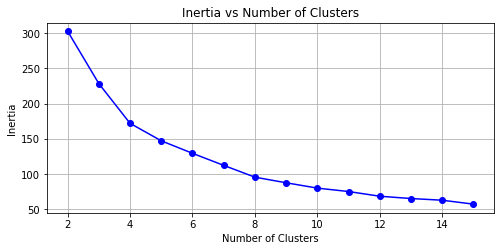

In [3]:
# Let's try to find the optimal number of clusters without any sort of dimension reduction
# The code below generates clusters using k-means for {2,...,16} clusters
kmeans_per_k = [KMeans(n_clusters=k).fit(scaled_data_matrix)for k in range(2, 16)] 
# We create an array that stores the inertias for each clustering above
inertias = [model.inertia_ for model in kmeans_per_k]
# We plot Interia vs Number of Clusters
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 16), inertias, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Inertia vs Number of Clusters")
plt.grid()
plt.show()
# It looks like 5 could be an "elbow" point (but trying higher values may be worth it)

In [4]:
# Let's cluster the data using five clusters
kmeans = KMeans(n_clusters = 4)
cluster = kmeans.fit_predict(scaled_data_matrix)
# Let's look at our cluster centers
print(kmeans.cluster_centers_)
# Note: we would want to run multiple times and take best one (best: minimizes distance between pts in cluster
# and cluster centers)

[[ 0.57505858 -0.2305793   0.60317449 -0.6814973  -0.28639515 -0.13429442]
 [-0.74814058 -0.45992607 -0.70025787  0.925666   -0.39772041 -0.13485835]
 [ 0.17741169  2.89953559 -0.68293189 -0.49440449 -1.31502269  7.9728813 ]
 [-0.14046682  1.3060724  -0.23725493  0.11419715  1.72210195 -0.07662458]]


Variance Ratio:  [0.33197491 0.24919664]
Total variance explained by principal components are:  0.5811715494723237


Text(0.5, 1.0, 'K Means Applied to PCA')

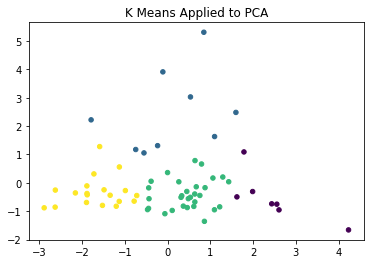

In [5]:
# To visualize our data,  need to reduce the dimension of our data from 6 to 2. 
# We can use principal component analysis (PCA) to do this. 
# Note: reducing our dimension to two does lead to inherent data loss.
# We want to find two prinicpal components:
pca = PCA(n_components = 2) 
pca_data = pca.fit_transform(scaled_data_matrix)
# Let's look at our variance ratio
print("Variance Ratio: ", pca.explained_variance_ratio_)
print("Total variance explained by principal components are: ", np.sum(pca.explained_variance_ratio_))
# Our reduction still explains almost 50% of the variance in the data
# We fit K-means on the scaled and reduced data. 
k_means_PCA = kmeans.fit_predict(pca_data)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c= k_means_PCA, s=20)
plt.title("K Means Applied to PCA") 

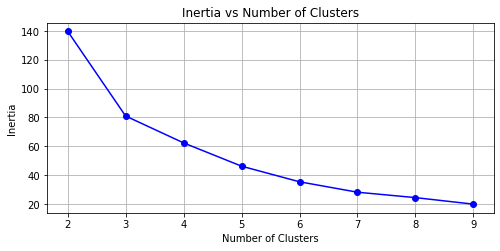

In [6]:
# Let's try to find the optimal number of clusters for our PCA data
# The code below generates clusters using k-means for {2,...,10} clusters
kmeans_per_k = [KMeans(n_clusters=k).fit(pca_data)for k in range(2, 10)] 
# We create an array that stores the inertias for each clustering above
inertias = [model.inertia_ for model in kmeans_per_k]
# We plot Interia vs Number of Clusters
plt.figure(figsize=(8, 3.5))
plt.plot(range(2, 10), inertias, "bo-")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Inertia vs Number of Clusters")
plt.grid()
plt.show()
# It looks like 3 is a possible "elbow" points 

Variance Ratio:  [0.33197491 0.24919664]
Total variance explained by principal components are:  0.5811715494723237


Text(0.5, 1.0, 'K Means Applied to PCA')

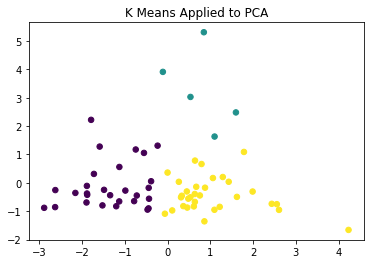

In [7]:
# Let's cluster the data using three clusters
kmeans_pca = KMeans(n_clusters = 3)
# Let's look at our variance ratio
print("Variance Ratio: ", pca.explained_variance_ratio_)
print("Total variance explained by principal components are: ", np.sum(pca.explained_variance_ratio_))
# The high value of the first entry indicates that there are features which "dominate" in terms of data variance
k_means_PCA = kmeans_pca.fit_predict(pca_data)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c= k_means_PCA, s=30)
plt.title("K Means Applied to PCA") # It looks like three clusters are indeed reasonable for this data

## Linear Programming

We now try and formulate a linear program to solve the constrained version of this problem. Assuming that we do not initially know the cluster centers, this is a non-linear mixed integer program (which is quite difficult to solve). If we do know our cluster centers, this is merely a classic supply and demand LP once we restrict the number of neighborhoods allowed in each cluster (i.e. constrain our problem). One potential approach to solving this problem consists of starting with some initialization of cluster centers, clustering our data (since we have our cluster centers this will be a linear program), moving the cluster centers closer to the bulk of the data in that cluster and then reclustering. We repeat this process until the cluster centers stop moving. Let's also suppose that we have 5 clusters each requiring 13 neighborhoods in each cluster (as this ensures that our data can be evenly divided amongst the clusters). Our task then becomes to find the optimal clustering of points given these cluster centers. We first define our parameters. Initially, let $x_{i}$ denote the feature vector associated with neighborhood $i$. We can then find the cost associated with cluster $j$ as: $c_{i,j}=\|x_{i} -\mathbf{\mu_{j}}\|_2$ (note that the $\mu_{j}$'s are known). We can formulate the following linear program to solve this problem:
$$
\mathrm{Minimize} \sum_{j = 1}^{5}\sum_{i = 1}^{65} c_{i,j}Y_{i,j}
$$ 
$$
\text{Subject to: }
\sum_{i = 1}^{65} Y_{i,j} = 13 \;
\forall j = 1, 2, 3, 4, 5
$$                   
$$
\sum_{j=1}^{5} Y_{i,j} = 1 \; \forall i = 1,2,...,65
$$
$$
Y_{i,j} \in \{0,1\}
$$
Additionally, we can try relaxing the integrality constraints in the event the problem becomes computationally infeasible. This relaxed problem is given below:
$$
\mathrm{Minimize} \sum_{j = 1}^{5}\sum_{i = 1}^{65} c_{i,j}Y_{i,j}
$$ 
$$
\text{Subject to: }
\sum_{i = 1}^{65} Y_{i,j} = 13 \;
\forall j = 1, 2, 3, 4, 5
$$ 
$$
\sum_{j=1}^{5} Y_{i,j} = 1 \; \forall i = 1,2,...,65
$$
$$
Y_{i,j} \in [0,1]
$$
We start by building our data:

In [8]:
# We redo our K-Means algorithm with 5 clusters (this is to ensure everything fits evenly in the clusters)
# and use the generated cluster centers to initialize our cluster centers. Note: We are working with the
# six-dimensional neighborhood data, not the PCA components.
kmeans_LP_init = KMeans(n_clusters = 5)
LP_init_k_means = kmeans_LP_init.fit_predict(scaled_data_matrix)
LP_cluster_centers_init = kmeans_LP_init.cluster_centers_

In [9]:
# We now construct our cost matrix 
cost = np.zeros((65,5))
for i in range(65):
    for j in range(5):
        cost[i,j] = np.linalg.norm(scaled_data_matrix[i]-LP_cluster_centers_init[j])
# We also create origin (neighborhood) vectors and destination (cluster) vectors and take care of the indices
orig = neighborhood_df["Neighborhood"].to_numpy()
dest = np.zeros(5)
for j in range(5):
    dest[j] = j
orig_df = pd.DataFrame(orig, columns = ["Neighborhood"]).set_index("Neighborhood")
dest_df = pd.DataFrame(dest, columns = ["Clusters"]).set_index("Clusters")
cost_df = pd.DataFrame(cost, columns = dest_df.index.to_list(),index = orig_df.index.to_list())
print(orig_df)
print(dest_df)
print(cost_df)
    

Empty DataFrame
Columns: []
Index: [Athmar Park, Baker, Barnum, Barnum West, Bear Valley, Belcaro, Berkeley, Capitol Hill, Chaffee Park, Cheesman Park, Cherry Creek, City Park, City Park West, Clayton, Cole, College View - South Platte, Congress Park, Cory - Merrill, Country Club, Denver International Airport, East Colfax, Elyria Swansea, Five Points, Fort Logan, Globeville, Goldsmith, Green Valley Ranch Denver, Hale, Hampden, Hampden South, Harvey Park, Harvey Park South, Highland, Hilltop, Indian Creek, Jefferson Park, Lincoln Park, Lowry Field, Mar Lee, Montbello, Montclair, Overland, Platt Park, Regis, Rosedale, Ruby Hill, Skyland, Sloan Lake, Southmoor Park, Speer, Stapleton Denver, Sun Valley, Sunnyside, University, Valverde, Villa Park, Virginia Village, Washington Park, Washington Park West, Washington Virginia Vale, Wellshire Denver, West Colfax, West Highland, Westwood, Windsor]

[65 rows x 0 columns]
Empty DataFrame
Columns: []
Index: [0.0, 1.0, 2.0, 3.0, 4.0]
              

In [10]:
# Now that we have our cost matrix, we can formulate an AMPL program to solve the resulting 
# supply and demand problem.
ampl = AMPL()
ampl.read("K_means_clustering.mod")
ampl.set_data(orig_df, "Neighborhood")
ampl.set_data(dest_df, "Clusters")
for n in range(10):
    ampl.get_parameter("cost").set_values(cost_df)
    ampl.option["solver"] = "highs"
    ampl.solve()
    # Now, we want to reformat our answer into something more readable. 
    clustering = ampl.get_variable("Cluster").get_values().to_pandas()
    clustering_temp = clustering.to_numpy().reshape(65,5) # Reshapes in 65 x 5
    # Code below creates an indicator matrix of neighborhoods and clusters
    clustering_temp2 = pd.DataFrame(clustering_temp, columns = dest_df.index.to_list(), index = orig_df.index.to_list())
    # Code block below translates indicator variables in to cluster number
    clustering_temp3 = clustering_temp2.idxmax(axis=1)
    # We add a column to be able to select specific clusters
    clustering_final = pd.DataFrame(clustering_temp3, columns = ["Group"],index = orig_df.index.to_list())
    # We find the neighborhoods in each cluster
    clust_0 = clustering_final.index[clustering_final["Group"] == 0.0].to_list()
    clust_1 = clustering_final.index[clustering_final["Group"] == 1.0].to_list()
    clust_2 = clustering_final.index[clustering_final["Group"] == 2.0].to_list()
    clust_3 = clustering_final.index[clustering_final["Group"] == 3.0].to_list()
    clust_4 = clustering_final.index[clustering_final["Group"] == 4.0].to_list()
    # We return to our original samples
    neigh_dat = pd.DataFrame(scaled_data_matrix, index = orig_df.index.to_list())
    # We create Numpy arrays of the original samples in each cluster
    orig_clust_0 = neigh_dat.loc[clust_0].to_numpy()
    orig_clust_1 = neigh_dat.loc[clust_1].to_numpy()
    orig_clust_2 = neigh_dat.loc[clust_2].to_numpy()
    orig_clust_3 = neigh_dat.loc[clust_3].to_numpy()
    orig_clust_4 = neigh_dat.loc[clust_4].to_numpy()
    new_clust_centers = np.zeros((5,6))
    new_clust_centers[0] = (1/orig_clust_0.shape[0])*np.sum(orig_clust_0, axis = 0)
    new_clust_centers[1] = (1/orig_clust_1.shape[0])*np.sum(orig_clust_1, axis = 0)
    new_clust_centers[2] = (1/orig_clust_2.shape[0])*np.sum(orig_clust_2, axis = 0)
    new_clust_centers[3] = (1/orig_clust_3.shape[0])*np.sum(orig_clust_3, axis = 0)
    new_clust_centers[4] = (1/orig_clust_4.shape[0])*np.sum(orig_clust_4, axis = 0)
    # We recompute our cost matrix
    for i in range(65):
        for j in range(5):
            cost[i,j] = np.linalg.norm(scaled_data_matrix[i]-new_clust_centers[j])
    cost_df = pd.DataFrame(cost, columns = [0.0,1.0,2.0,3.0,4.0],index = orig_df.index.to_list())
print(clustering_final)
print(new_clust_centers)





HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 178.4889836
78 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 100.2529459
27 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 98.76794351
21 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 98.4790646
5 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 98.06702068
6 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 98.06702068
0 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 98.06702068
0 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 98.06702068
0 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3:HiGHS 1.5.3: optimal solution; objective 98.06702068
0 simplex iterations
0 barrier iterations
 
HiGHS 1.5.3:HiGHS

In [11]:
# The code below outputs the entire dataframe as opposed to a truncated display. 
# We can see what cluster each neighborhood belongs to. 
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(clustering_final)


                              Group
Athmar Park                     1.0
Baker                           2.0
Barnum                          1.0
Barnum West                     4.0
Bear Valley                     4.0
Belcaro                         0.0
Berkeley                        4.0
Capitol Hill                    3.0
Chaffee Park                    1.0
Cheesman Park                   4.0
Cherry Creek                    3.0
City Park                       2.0
City Park West                  2.0
Clayton                         1.0
Cole                            2.0
College View - South Platte     1.0
Congress Park                   0.0
Cory - Merrill                  0.0
Country Club                    0.0
Denver International Airport    2.0
East Colfax                     4.0
Elyria Swansea                  2.0
Five Points                     3.0
Fort Logan                      4.0
Globeville                      2.0
Goldsmith                       1.0
Green Valley Ranch Denver   

In [12]:
print("The final cluster centers are: ", scaler.inverse_transform(new_clust_centers))

The final cluster centers are:  [[2.24830769e+03 3.02146154e+03 1.14832132e+05 3.78015385e-01
  3.34607692e+03 9.56076923e+00]
 [1.61069231e+03 2.30330769e+03 4.68660054e+04 5.53076923e-01
  2.92638462e+03 1.18861538e+01]
 [2.20776923e+03 7.14207692e+03 5.03502292e+04 4.89230769e-01
  2.34146154e+03 1.00904846e+03]
 [1.96984615e+03 1.16021538e+04 6.56120169e+04 4.66923077e-01
  8.25853846e+03 8.99753846e+01]
 [2.04346154e+03 1.57653846e+03 6.64523700e+04 3.95384615e-01
  3.38007692e+03 1.46684615e+01]]


In [13]:
# The neighborhoods in each cluster don't seem to change from iteration to iteration but the order of the clusters changes
print(clust_0)
print(clust_1)
print(clust_2)
print(clust_3)
print(clust_4)

['Belcaro', 'Congress Park', 'Cory - Merrill', 'Country Club', 'Highland', 'Hilltop', 'Lowry Field', 'Platt Park', 'Rosedale', 'Washington Park', 'Washington Park West', 'Wellshire Denver', 'West Highland']
['Athmar Park', 'Barnum', 'Chaffee Park', 'Clayton', 'College View - South Platte', 'Goldsmith', 'Harvey Park', 'Harvey Park South', 'Mar Lee', 'Regis', 'Ruby Hill', 'Valverde', 'Westwood']
['Baker', 'City Park', 'City Park West', 'Cole', 'Denver International Airport', 'Elyria Swansea', 'Globeville', 'Jefferson Park', 'Lincoln Park', 'Sun Valley', 'University', 'Villa Park', 'West Colfax']
['Capitol Hill', 'Cherry Creek', 'Five Points', 'Green Valley Ranch Denver', 'Hale', 'Hampden', 'Hampden South', 'Montbello', 'Speer', 'Stapleton Denver', 'Virginia Village', 'Washington Virginia Vale', 'Windsor']
['Barnum West', 'Bear Valley', 'Berkeley', 'Cheesman Park', 'East Colfax', 'Fort Logan', 'Indian Creek', 'Montclair', 'Overland', 'Skyland', 'Sloan Lake', 'Southmoor Park', 'Sunnyside']